In [ ]:
pip install tensorflow numpy matplotlib

In [11]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# ==========================================
# 1. CONFIGURATION & INPUT PARAMETERS [cite: 14, 15]
# ==========================================
print("--- GAN Configuration ---")
DATASET_CHOICE = 'mnist'  # Fixed as per user request
EPOCHS = int(input("Enter Epochs (rec. 30-100): ") or 50) # [cite: 17]
BATCH_SIZE = int(input("Enter Batch Size (rec. 64/128): ") or 128) # [cite: 18]
NOISE_DIM = int(input("Enter Noise Dimension (rec. 100): ") or 100) # [cite: 19]
LEARNING_RATE = 0.0002 # [cite: 20]
SAVE_INTERVAL = int(input("Enter Save Interval (rec. 5): ") or 5) # [cite: 21]

# Create directories for outputs [cite: 40, 43]
os.makedirs('generated_samples', exist_ok=True)
os.makedirs('final_generated_images', exist_ok=True)

# ==========================================
# 2. LOAD & PREPROCESS DATA [cite: 9, 10, 13]
# ==========================================
print(f"\nLoading {DATASET_CHOICE} dataset...")
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

# Normalize to range [-1, 1]
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5

# Batch and shuffle the data
dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(60000).batch(BATCH_SIZE)

# ==========================================
# 3. BUILD MODELS [cite: 23, 24, 25]
# ==========================================

def build_generator():
    """Designs the Generator network"""
    model = models.Sequential()
    # Foundation for 7x7 image
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(NOISE_DIM,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))

    # Upsample to 14x14
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Upsample to 28x28
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Output layer (tanh activation for [-1, 1] range) [cite: 31]
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    return model

def build_discriminator():
    """Designs the Discriminator network"""
    model = models.Sequential()

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1)) # Output logic (real/fake score)
    return model

generator = build_generator()
discriminator = build_discriminator()

# Loss and Optimizers [cite: 32]
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
discriminator_optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

# ==========================================
# 4. TRAINING LOGIC
# ==========================================

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    # Calculate approximate accuracy for logging
    # Real images > 0 is True, Fake images < 0 is True (since logits)
    real_acc = tf.reduce_mean(tf.cast(real_output > 0, tf.float32))
    fake_acc = tf.reduce_mean(tf.cast(fake_output < 0, tf.float32))
    d_acc = (real_acc + fake_acc) * 0.5 * 100

    return gen_loss, disc_loss, d_acc

def save_plot(examples, epoch, n=5):
    """Saves a grid of generated images [cite: 33, 40, 41]"""
    # Scale from [-1,1] to [0,1] for plotting
    examples = (examples + 1) / 2.0

    plt.figure(figsize=(10, 10))
    for i in range(n * n):
        plt.subplot(n, n, i+1)
        plt.axis('off')
        plt.imshow(examples[i, :, :, 0], cmap='gray')

    filename = f'generated_samples/epoch_{epoch:02d}.png'
    plt.savefig(filename)
    plt.close()

# ==========================================
# 5. PRE-TRAINED CLASSIFIER (For Output 4)
# ==========================================
# Since we need to predict labels, we quickly train a standard classifier on MNIST
# or load one if available. We will train a simple one here for completeness.
print("\nPreparing classifier for evaluation...")
classifier = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])
classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Train on a small subset just to make it functional for the lab demonstration
classifier.fit(train_images[:10000], train_labels[:10000], epochs=3, verbose=0)
print("Classifier ready.")

# ==========================================
# 6. MAIN TRAINING LOOP [cite: 26, 36]
# ==========================================
print("\nStarting GAN Training...")
seed = tf.random.normal([25, NOISE_DIM]) # Seed for consistent visualization

for epoch in range(1, EPOCHS + 1):
    gen_losses = []
    disc_losses = []
    disc_accs = []

    for image_batch in dataset:
        g_loss, d_loss, d_acc = train_step(image_batch)
        gen_losses.append(g_loss)
        disc_losses.append(d_loss)
        disc_accs.append(d_acc)

    # Calculate average stats for the epoch
    avg_g_loss = np.mean(gen_losses)
    avg_d_loss = np.mean(disc_losses)
    avg_d_acc = np.mean(disc_accs)

    # Output 1: Training Logs [cite: 37, 38]
    print(f"Epoch {epoch}/{EPOCHS} | D_loss: {avg_d_loss:.2f} | D_acc: {avg_d_acc:.2f}% | G_loss: {avg_g_loss:.2f}")

    # Output 2: Save generated samples periodically [cite: 27, 41]
    if epoch % SAVE_INTERVAL == 0:
        fake_images = generator(seed, training=False)
        save_plot(fake_images.numpy(), epoch)
        print(f"  > Saved generated samples for epoch {epoch}")

import shutil # Import shutil to help organize folders

# ==========================================
# 7. FINAL GENERATION & SORTED SAVING
# ==========================================
print("\n--- Final Phase: Generating and Sorting ---")

# [cite_start]1. Generate the 100 synthetic images [cite: 43]
print("Generating 100 synthetic images...")
final_noise = tf.random.normal([100, NOISE_DIM])
final_images = generator(final_noise, training=False)

# [cite_start]2. Predict labels using the pre-trained LeNet-5 classifier [cite: 44]
print("Classifying generated images...")
predictions = classifier.predict(final_images, verbose=0)
predicted_labels = np.argmax(predictions, axis=1)

# 3. Save images into labeled folders
base_dir = 'final_generated_images'

# Optional: Clear the directory first to avoid mixing old results
if os.path.exists(base_dir):
    shutil.rmtree(base_dir)
os.makedirs(base_dir)

print(f"Saving images to '{base_dir}/' sorted by label...")

for i in range(100):
    # Get the image and its predicted label
    img_array = final_images[i].numpy()
    label = predicted_labels[i]

    # Create a folder for this specific label (e.g., "final_generated_images/7")
    label_folder = os.path.join(base_dir, str(label))
    os.makedirs(label_folder, exist_ok=True)

    # Process image for saving (Rescale from [-1, 1] to [0, 255])
    img_array = (img_array + 1) / 2.0 * 255.0
    img_array = img_array.astype(np.uint8)

    # Save the file with a unique name
    filename = f"img_{i+1}_pred_{label}.png"
    save_path = os.path.join(label_folder, filename)
    tf.keras.utils.save_img(save_path, img_array)

print("Images saved successfully.")

# 4. Report the final distribution
unique, counts = np.unique(predicted_labels, return_counts=True)
print("\n--- Distribution of Generated Images ---")
for label, count in zip(unique, counts):
    print(f"Digit {label}: {count} images saved")

print("\nLab Completed Successfully.")

--- GAN Configuration ---
Enter Epochs (rec. 30-100): 30
Enter Batch Size (rec. 64/128): 64
Enter Noise Dimension (rec. 100): 100
Enter Save Interval (rec. 5): 10

Loading mnist dataset...

Preparing classifier for evaluation...
Classifier ready.

Starting GAN Training...
Epoch 1/30 | D_loss: 0.98 | D_acc: 77.14% | G_loss: 1.26
Epoch 2/30 | D_loss: 1.13 | D_acc: 71.69% | G_loss: 1.19
Epoch 3/30 | D_loss: 1.06 | D_acc: 74.12% | G_loss: 1.25
Epoch 4/30 | D_loss: 1.01 | D_acc: 75.64% | G_loss: 1.34
Epoch 5/30 | D_loss: 0.91 | D_acc: 78.81% | G_loss: 1.56
Epoch 6/30 | D_loss: 0.91 | D_acc: 78.84% | G_loss: 1.61
Epoch 7/30 | D_loss: 0.96 | D_acc: 76.88% | G_loss: 1.47
Epoch 8/30 | D_loss: 1.03 | D_acc: 74.50% | G_loss: 1.42
Epoch 9/30 | D_loss: 1.09 | D_acc: 72.21% | G_loss: 1.25
Epoch 10/30 | D_loss: 1.13 | D_acc: 70.74% | G_loss: 1.18
  > Saved generated samples for epoch 10
Epoch 11/30 | D_loss: 1.14 | D_acc: 70.40% | G_loss: 1.14
Epoch 12/30 | D_loss: 1.15 | D_acc: 70.35% | G_loss: 1.13

Displaying generated images at each save interval:


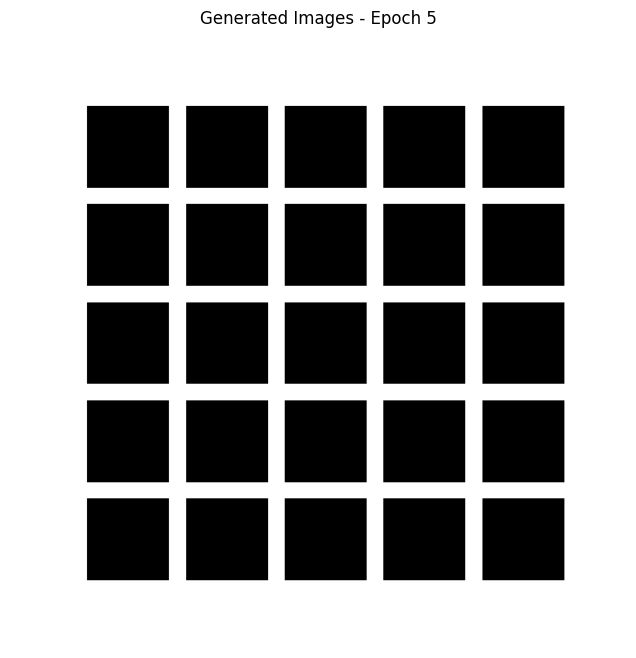

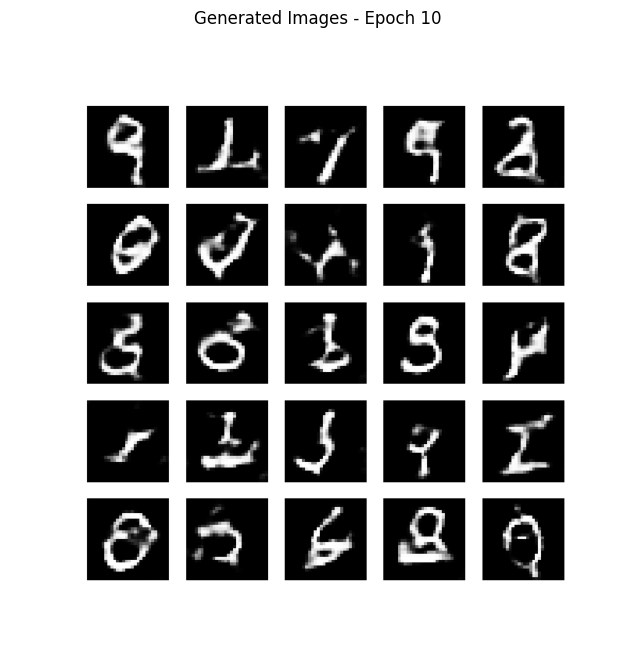

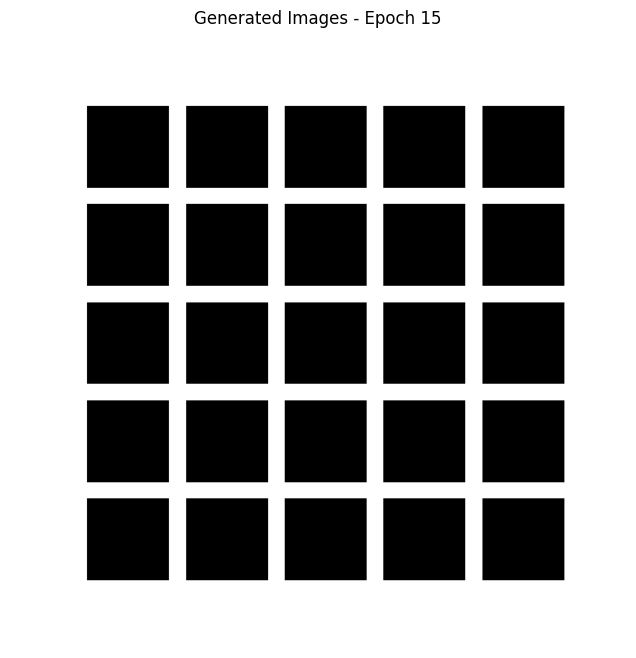

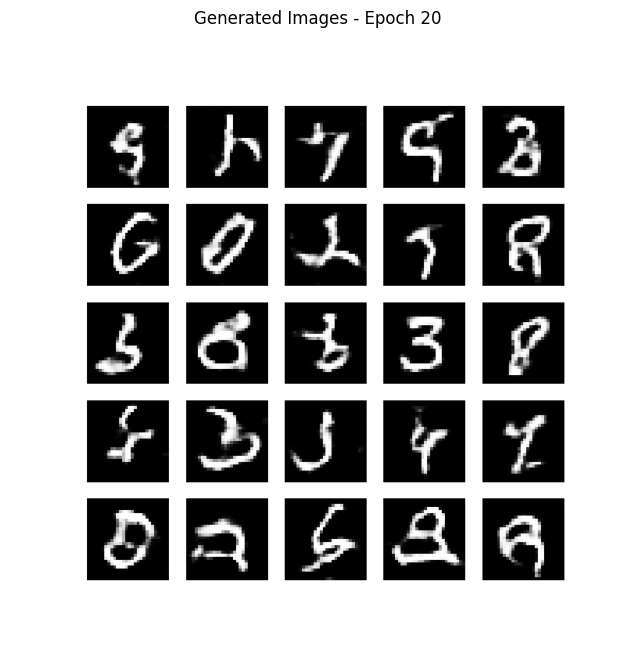

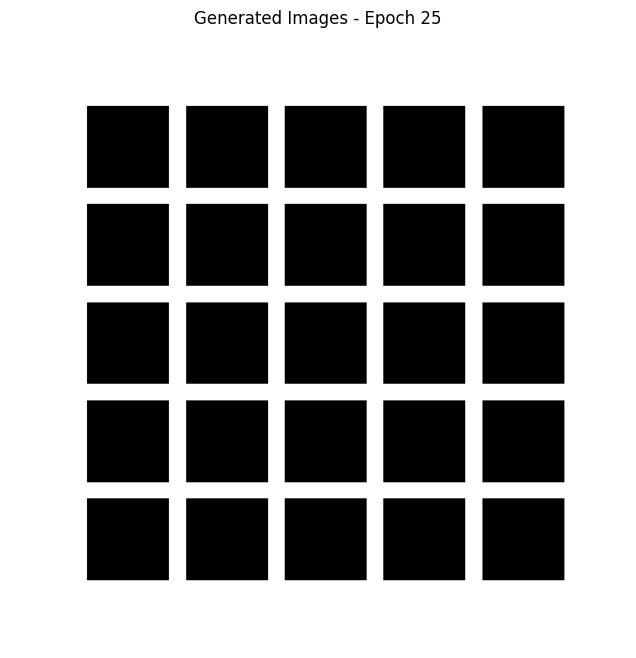

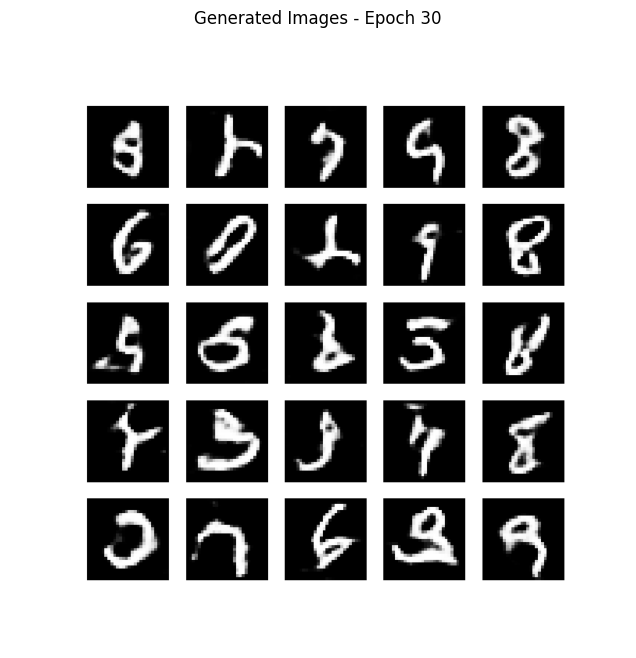

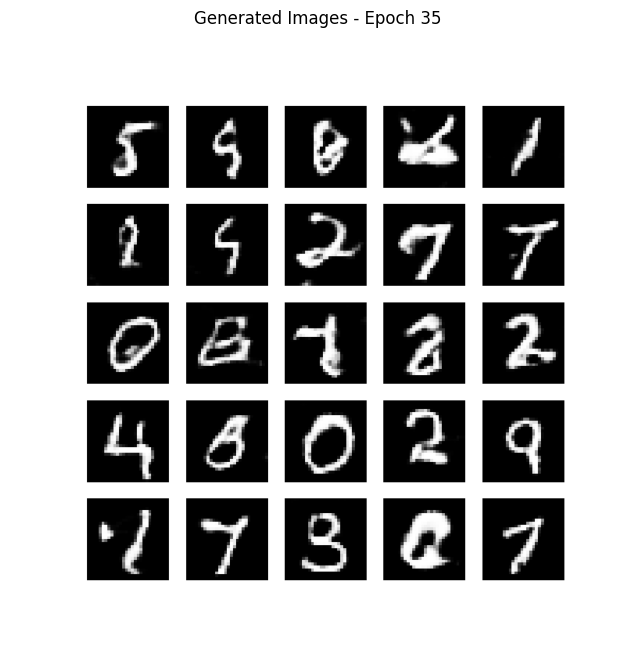

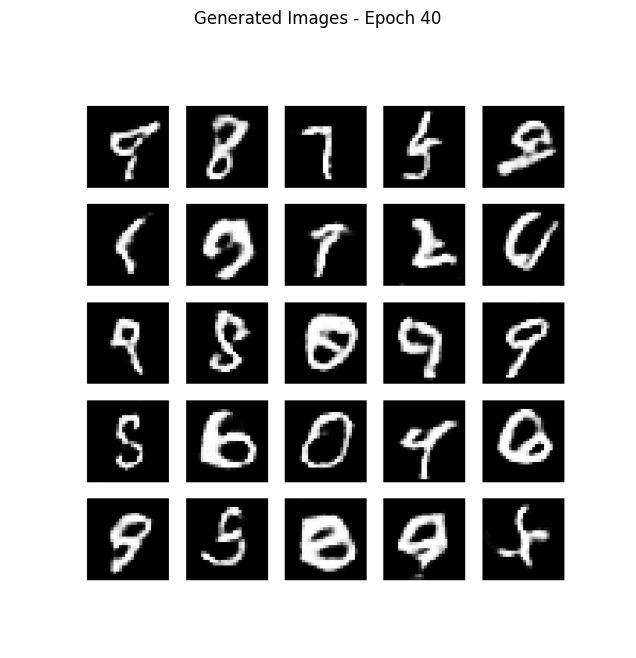

In [12]:
import os
import matplotlib.pyplot as plt

# Get all generated sample image files
image_files = [f for f in os.listdir('generated_samples') if f.startswith('epoch_') and f.endswith('.png')]

# Sort files by epoch number
image_files.sort(key=lambda x: int(x.split('_')[1].split('.')[0]))

print("Displaying generated images at each save interval:")

for img_file in image_files:
    epoch_num = int(img_file.split('_')[1].split('.')[0])
    img_path = os.path.join('generated_samples', img_file)

    plt.figure(figsize=(8, 8))
    plt.imshow(plt.imread(img_path))
    plt.axis('off')
    plt.title(f'Generated Images - Epoch {epoch_num}')
    plt.show()

### Evaluate LeNet-5 Accuracy on Generated Images

Now that the generated images are sorted into labeled folders, we can evaluate the LeNet-5 classifier's accuracy using these folder names as the ground truth.

In [14]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from sklearn.metrics import accuracy_score

print("\n--- Evaluating LeNet-5 on Generated Images ---")

# Path to the directory containing labeled generated images
base_dir = 'final_generated_images'

# Lists to store loaded images and their true labels
loaded_images = []
true_labels = []

# Load images from labeled folders
for label_folder in os.listdir(base_dir):
    if os.path.isdir(os.path.join(base_dir, label_folder)):
        label = int(label_folder)
        folder_path = os.path.join(base_dir, label_folder)
        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            # Load image and preprocess it for the classifier
            img = image.load_img(img_path, color_mode='grayscale', target_size=(28, 28))
            img_array = image.img_to_array(img)
            img_array = img_array / 127.5 - 1 # Normalize to [-1, 1] range as used for GAN training
            loaded_images.append(img_array)
            true_labels.append(label)

if not loaded_images:
    print("No generated images found in labeled folders. Please ensure the previous step ran correctly.")
else:
    # Convert lists to numpy arrays
    loaded_images = np.array(loaded_images)
    true_labels = np.array(true_labels)

    print(f"Loaded {len(loaded_images)} generated images with ground truth labels.")

    # Use the trained LeNet-5 classifier to predict labels
    predictions = classifier.predict(loaded_images, verbose=0)
    predicted_labels = np.argmax(predictions, axis=1)

    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predicted_labels)

    print(f"\nLeNet-5 Classifier Accuracy on Generated Images: {accuracy:.4f}")

    print("\n--- Detailed Predictions (Every 5th Image) ---")
    for i in range(0, len(loaded_images), 5):
        true_l = true_labels[i]
        predicted_l = predicted_labels[i]
        is_correct = "Correct" if true_l == predicted_l else "Incorrect"
        print(f"Image {i+1}: True Label: {true_l}, Predicted Label: {predicted_l}, Result: {is_correct}")



--- Evaluating LeNet-5 on Generated Images ---
Loaded 100 generated images with ground truth labels.

LeNet-5 Classifier Accuracy on Generated Images: 0.9900

--- Detailed Predictions (Every 5th Image) ---
Image 1: True Label: 2, Predicted Label: 2, Result: Correct
Image 6: True Label: 2, Predicted Label: 2, Result: Correct
Image 11: True Label: 2, Predicted Label: 2, Result: Correct
Image 16: True Label: 9, Predicted Label: 9, Result: Correct
Image 21: True Label: 9, Predicted Label: 9, Result: Correct
Image 26: True Label: 7, Predicted Label: 7, Result: Correct
Image 31: True Label: 7, Predicted Label: 7, Result: Correct
Image 36: True Label: 1, Predicted Label: 1, Result: Correct
Image 41: True Label: 1, Predicted Label: 1, Result: Correct
Image 46: True Label: 1, Predicted Label: 1, Result: Correct
Image 51: True Label: 5, Predicted Label: 5, Result: Correct
Image 56: True Label: 5, Predicted Label: 5, Result: Correct
Image 61: True Label: 4, Predicted Label: 4, Result: Correct
Im